# Real-time analysis

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
from xhistogram.xarray import histogram
from rasterio import features
import zarr
import rioxarray
import s3fs
import matplotlib.pyplot as plt
from affine import Affine
from ast import literal_eval
from shapely.geometry import Polygon

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

## Utils
**plot_hist**

In [3]:
def plot_hist(x_min, count):
    width = x_min[1]-x_min[0]
    width -= width/5.
    x_min += width/(5.*2)
    per = count/count.sum()*100
    
    plt.figure(figsize=(10,5))
    
    plt.bar(x_min, per, width=width)
    
    plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')
    
    plt.title('Soil Organic Carbon Stock')
    plt.xlabel('SOC stock t C/ha)')
    plt.ylabel('(%) of total area')

**transform_from_latlon**

In [4]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

**rasterize**

In [5]:
def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

**read_dataset**

In [6]:
def read_dataset(dataset_type, group, access_key_id, secret_accsess_key):
    # AWS S3 path
    s3_path = f's3://soils-revealed/{dataset_type}.zarr'
    # Initilize the S3 file system
    s3 = s3fs.S3FileSystem(key=access_key_id, secret=secret_accsess_key)
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    # Read Zarr file
    ds = xr.open_zarr(store=store, group=group, consolidated=True)
    
    # Change coordinates names
    ds = ds.rename({'x': 'lon', 'y': 'lat'})
    
    # Change depth coord from 0 to 1 dimensional array
    depths = ds.coords.get('depth').values
    if depths.ndim == 0: 
        ds = ds.squeeze().drop("depth")
        ds = ds.assign_coords({"depth": np.array([depths])})
        
    return ds 

## Read `xarray.Dataset` from `Zarr` in Amazon S3 bucket

In [7]:
%%time
ds = read_dataset(dataset_type = 'experimental-dataset', group = 'stocks', 
                  access_key_id = os.getenv("S3_ACCESS_KEY_ID"), 
                  secret_accsess_key = os.getenv("S3_SECRET_ACCESS_KEY"))

ds

CPU times: user 332 ms, sys: 11.3 ms, total: 343 ms
Wall time: 11.5 s


,Array,Chunk
Bytes,19.74 GB,2.14 MB
Shape,"(36, 13883, 9872)","(1, 868, 617)"
Count,9217 Tasks,9216 Chunks
Type,float32,numpy.ndarray


## Zonal statistics

**Polygon**

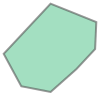

In [8]:
polygon = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -63.34716796874999,
              -34.234512362369856
            ],
            [
              -64.22607421875,
              -35.17380831799957
            ],
            [
              -63.896484375,
              -35.78217070326606
            ],
            [
              -63.34716796874999,
              -35.88905007936092
            ],
            [
              -62.86376953124999,
              -35.46066995149529
            ],
            [
              -62.51220703125,
              -35.08395557927643
            ],
            [
              -62.49023437499999,
              -34.57895241036947
            ],
            [
              -63.34716796874999,
              -34.234512362369856
            ]
          ]
        ]
      }
    }
  ]
}

geometry = Polygon(polygon.get('features')[0].get('geometry').get('coordinates')[0])
geometry

**Create the data mask by rasterizing the vector data**

In [9]:
shapes = zip([geometry], range(1))
da_mask = rasterize(shapes, ds.coords, longitude='lon', latitude='lat').rename('mask')
ds['mask'] = da_mask

## Change

**Input variables**

In [10]:
years = ['1982', '2017']
depth = '0-30'
nBinds=80
bindsRange=[-50, 50]

**Computation**

In [11]:
start_date = np.datetime64(datetime.strptime(f'{years[0]}-12-31', "%Y-%m-%d"))
end_date = np.datetime64(datetime.strptime(f'{years[1]}-12-31', "%Y-%m-%d"))

xmin, ymax, xmax, ymin = geometry.bounds
xds_index = ds.where(ds['mask'].isin(0.0)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))

# Get difference between two dates
diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]

# Get counts and binds of the histogram
bins = np.linspace(bindsRange[0], bindsRange[1], nBinds+1)
h = histogram(diff.stocks, bins=[bins], dim=['lat', 'lon'])

count = h.values
mean_diff = diff['stocks'].mean(skipna=True).values 

**Output values**

Soil Organic Carbon Stock Change: -0.2455104282924107 t C/ha year


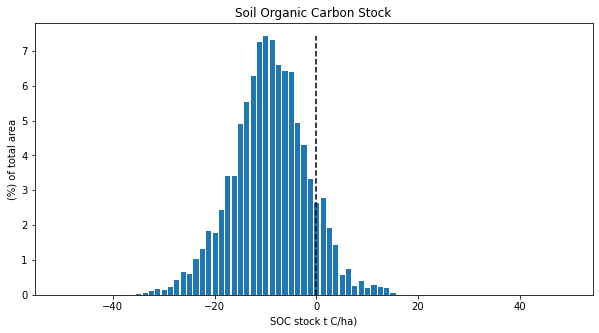

In [12]:
print(f'Soil Organic Carbon Stock Change: {mean_diff/(int(years[1])-int(years[0]))} t C/ha year')
x_min = bins[:-1]
plot_hist(x_min, count)

## Time series

**Computation**

In [14]:
years = [int(str(x).split('-')[0]) for x in ds.coords.get('time').values]

xmin, ymax, xmax, ymin = geometry.bounds
xds_index = ds.where(ds['mask'].isin(0.0)).sel(depth='0-30', lon=slice(xmin, xmax), lat=slice(ymin, ymax))

values = xds_index['stocks'].mean(['lon', 'lat']).values

**Output values**

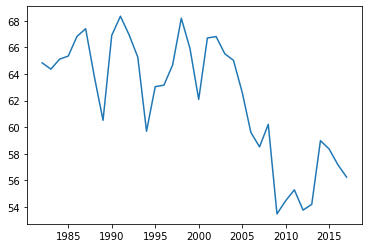

In [15]:
plt.plot(years, values)